In [1]:
import os
import torch

torch.manual_seed(0)

os.getcwd()

os.chdir("./src")

In [2]:
from diffusion_model_discrete import DiscreteDenoisingDiffusion
from new_functions import mol_to_data, clean_and_convert_samples
import torch

model = DiscreteDenoisingDiffusion.load_from_checkpoint("./outputs/checkpoint_moses.ckpt", map_location=torch.device('cuda'))

Lightning automatically upgraded your loaded checkpoint from v1.6.5 to v2.3.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint outputs/checkpoint_moses.ckpt`


Mini moses not found, Moses dataset cannot be used
Found rdkit, all good


/home/kkladny/anaconda3/envs/digress/lib/python3.9/site-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/home/kkladny/anaconda3/envs/digress/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'train_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['train_metrics'])`.
/home/kkladny/anaconda3/envs/digress/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'sampling_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['sampling_metrics'])`.


Marginal distribution of the classes: tensor([0.5664, 0.1071, 0.1283, 0.0812, 0.1115, 0.0042, 0.0012, 0.0000],
       device='cuda:0') for nodes, tensor([8.4956e-01, 4.4773e-02, 5.9329e-02, 3.3361e-04, 4.6009e-02],
       device='cuda:0') for edges


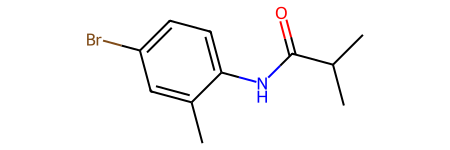

In [3]:
import moses

test_smile = 'Cc1cc(Br)ccc1NC(=O)C(C)C'
#test_smile = 'COc1ccc(-c2nc3n(c2-c2ccncc2)CCC3)cc1'
# plot the test molecule
from rdkit import Chem
from rdkit.Chem import Draw
mol = Chem.MolFromSmiles(test_smile)
mol_data = mol_to_data(mol)
mol

In [4]:
from analysis.visualization import MolecularVisualization
from datasets.moses_dataset import MOSESinfos, MOSESDataModule
from hydra import compose, initialize

with initialize(version_base=None, config_path="configs"):
    cfg = compose(config_name="config")

datamodule = MOSESDataModule(cfg=cfg)
infos = MOSESinfos(datamodule=datamodule)
vis = MolecularVisualization(remove_h=True, dataset_infos=infos)

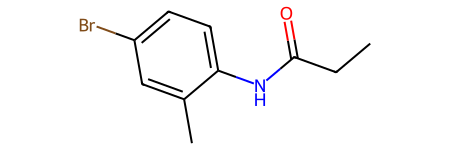

In [5]:
atom_count = mol.GetNumAtoms()
mol_data_cropped = (mol_data[0][:, :(atom_count-1)], mol_data[1][:, :(atom_count-1), :(atom_count-1)])
mol_cropped = vis.mol_from_graphs(mol_data_cropped[0][0], mol_data_cropped[1][0])
mol_cropped

In [6]:
# compute amount of possible ways to add exactly one atom to the molecule

def get_possible_attachments(mol):
    """Get a list of atoms in the molecule where a new atom can be attached."""
    attachment_points = []
    for atom in mol.GetAtoms():
        attachment_points.append(atom.GetIdx())
    return attachment_points

def add_atom_to_molecule(mol, atom_symbol, atom_idx, bond_type):
    """Add an atom to the molecule at the specified atom index with a specified bond type."""
    editable_mol = Chem.RWMol(mol)
    new_atom = Chem.Atom(atom_symbol)
    new_idx = editable_mol.AddAtom(new_atom)
    editable_mol.AddBond(atom_idx, new_idx, bond_type)
    return editable_mol.GetMol()

def get_possible_additions(mol, new_atoms):
    """Get all possible molecules generated by adding each atom in new_atoms to the molecule with different bond types."""
    from rdkit import RDLogger
    RDLogger.DisableLog('rdApp.*')
    attachment_points = get_possible_attachments(mol)
    bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]
    new_molecules = []
    for atom_symbol in new_atoms:
        for atom_idx in attachment_points:
            for bond_type in bond_types:
                try:
                    new_mol = add_atom_to_molecule(mol, atom_symbol, atom_idx, bond_type)
                    Chem.SanitizeMol(new_mol)
                    new_molecules.append(new_mol)
                except Exception as e:
                    # Skip invalid molecules
                    pass
    return new_molecules

# Example molecule (Cyclohexane)
smiles = test_smile
mol = Chem.MolFromSmiles(smiles)

# Define the new atoms that can be added (e.g., C, O, N, H)
new_atoms = ['C', 'N', 'S', 'O', 'F', 'Cl', 'Br', 'H']

# Get all possible new molecules
new_molecules = get_possible_additions(mol, new_atoms)

# Count the number of possible ways to add one atom
num_possible_additions = len(new_molecules)
print(f"The number of possible ways to add one atom is: {num_possible_additions}")

The number of possible ways to add one atom is: 86


In [8]:
samples = model.sample_batch(batch_id=1, batch_size=128, keep_chain=1, number_chain_steps=1, save_final=1, num_nodes=atom_count, scaffold_mask=(mol_data_cropped[0][0], mol_data_cropped[1][0]))

In [9]:
samples_mol = clean_and_convert_samples(samples)

from rdkit.Chem import MACCSkeys
#fps = [AllChem.GetMorganFingerprintAsBitVect(sample, 2, useChirality=True) for sample in samples_mol]
fps = [MACCSkeys.GenMACCSKeys(sample) for sample in samples_mol]
len(fps)

22

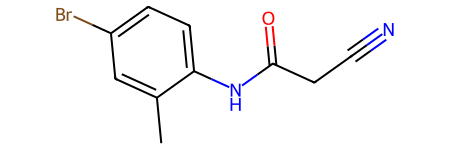

In [14]:
samples_mol[0]

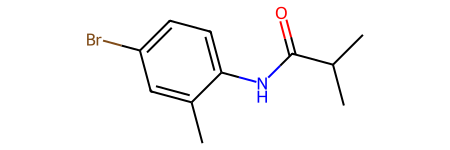

In [11]:
mol

In [13]:
# compute similarities to original molecule
#fps_mol = AllChem.GetMorganFingerprintAsBitVect(mol, 2, useChirality=True)
fps_mol = MACCSkeys.GenMACCSKeys(mol)
from rdkit import DataStructs
similarities = [DataStructs.TanimotoSimilarity(fps_mol, fp) for fp in fps]
similarities

[0.65625,
 0.7333333333333333,
 1.0,
 0.7333333333333333,
 0.65625,
 0.7931034482758621,
 0.75,
 0.65625,
 0.5526315789473685,
 0.46511627906976744,
 0.4,
 0.7931034482758621,
 0.6875,
 0.7333333333333333,
 0.5121951219512195,
 0.7931034482758621,
 0.525,
 0.6666666666666666,
 0.7096774193548387,
 0.3877551020408163,
 0.6470588235294118,
 0.4418604651162791]

In [12]:
#samples_mol[similarities.index(max(similarities))]
# plot first 5 samples
from new_functions import generate_non_substructure_vis, combine_svg_strings
pics = [generate_non_substructure_vis(sample, mol_cropped) for sample in samples_mol[:10]]
#Draw.MolsToGridImage(samples_mol[:10], molsPerRow=10, subImgSize=(200,200))
combine_svg_strings(pics, "non_substructures.svg")

Combined SVG saved to non_substructures.svg.


In [7]:
# compute similiraties between samples
#fps = [AllChem.GetMorganFingerprintAsBitVect(mol_gen, 2, useChirality=True) for mol_gen in samples_mol]
from rdkit.Chem import MACCSkeys
fps = [MACCSkeys.GenMACCSKeys(mol_gen) for mol_gen in samples_mol]
# plot as heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
similarity_matrix = [[DataStructs.TanimotoSimilarity(fp1, fp2) for fp1 in fps] for fp2 in fps]
sns.heatmap(similarity_matrix, cmap='viridis', annot=True, fmt=".2f")

NameError: name 'samples_mol' is not defined

In [ ]:
count = 0
temp = similarity_matrix
# set diagonal to 0
for i in range(len(temp)):
    temp[i][i] = 0
for i in range(len(temp)):
    if max(temp[i]) >= 0.85:
        count += 1
count/len(similarities)

0.5454545454545454

In [ ]:
def count_atoms(mol):
    """Count the number of each type of atom in a molecule."""
    atom_counts = {"C": 0, "O": 0, "H": 0, "N" : 0}
    for atom in mol.GetAtoms():
        element = atom.GetSymbol()
        if element in atom_counts:
            atom_counts[element] += 1
    return atom_counts

def has_exact_atom_counts(atom_counts, required_counts):
    """Check if the molecule has the exact required number of specific atoms."""
    for element, count in required_counts.items():
        if atom_counts.get(element, 0) != count:
            return False
    return True

def filter_molecules_by_exact_atom_counts(smiles_list, required_counts):
    """Filter molecules based on the exact counts of specific atoms."""
    valid_mols = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            atom_counts = count_atoms(mol)
            if has_exact_atom_counts(atom_counts, required_counts):
                valid_mols.append(mol)
    return valid_mols

/home/kkladny/conformal_prediction_generative_models/DiGress/src


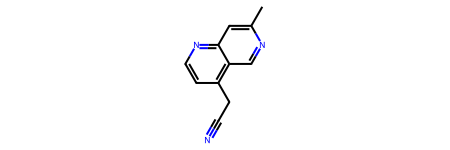

In [ ]:
from rdkit.Chem import SanitizeMol

def write_molecules_to_sdf(molecules, filename):
    writer = SDWriter(filename)
    for mol in molecules:
        if mol is not None:
            try:
                # Attempt to sanitize the molecule without kekulization
                SanitizeMol(mol, sanitizeOps=SanitizeFlags.SANITIZE_ALL ^ SanitizeFlags.SANITIZE_KEKULIZE)
                writer.write(mol)
            except Exception as e:
                print(f"Skipping molecule due to sanitization error: {e}")
    writer.close()

#write_molecules_to_sdf(valid_mols, "valid_mols.sdf")
# load molecules from file
from rdkit.Chem import SDMolSupplier
print(os.getcwd())
supplier = SDMolSupplier("valid_mols.sdf")
mols = [mol for mol in supplier if mol is not None]
mols[8]